### Iz eksploratorne


In [0]:
import functools
import warnings

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
%matplotlib inline
import pickle

from keras import backend as K
import gc
import time
import math

In [0]:
data = pd.read_csv('train.tsv', sep='\t')
test=pd.read_csv('test.tsv', sep='\t')

data.set_index('train_id', inplace=True) # stavimo da train_id bude indeks, onaj kojeg pandas kreira je nepotreban
test.set_index('test_id', inplace=True)

"Mala" nadopuna missing vrijednosti brand_name

In [0]:
brandovi1=data['brand_name']
brandovi2=test['brand_name']
svi_brandovi1=set(brandovi1.values)
svi_brandovi2=set(brandovi1.values)

svi_brandovi1 = {x for x in svi_brandovi1 if pd.notna(x)}
svi_brandovi2 = {x for x in svi_brandovi1 if pd.notna(x)}

svi_brandovi1-={'M', 'K', 'X'}
svi_brandovi2-={'M', 'K', 'X'}

def trazilica1(objekt):
    brand=objekt[0]
    ime=objekt[1]
    if pd.isna(brand):
        for i in svi_brandovi1:
            if i in ime:
                return i
    return brand
  
def trazilica2(objekt):
    brand=objekt[0]
    ime=objekt[1]
    if pd.isna(brand):
        for i in svi_brandovi2:
            if i in ime:
                return i
    return brand
data['brand_name']=data[['brand_name', 'name']].apply(trazilica1, axis=1)
test['brand_name']=test[['brand_name', 'name']].apply(trazilica2, axis=1)

Kako se izboriti s missing vrijednostima

In [0]:
def handle_missing_inplace(dataset):
    dataset['subcat1'].fillna(value='No Label', inplace=True)
    dataset['subcat2'].fillna(value='No Label', inplace=True)
    dataset['subcat3'].fillna(value='No Label', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].fillna(value='No description yet', inplace=True)

Funkcija za odvajanje kategorija

In [0]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

Funkcija za računanje rmsle

In [0]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 \
              for i, pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5


Podjela na 3 kategorije.

In [0]:
data['subcat1'], data['subcat2'], data['subcat3'] = \
zip(*data['category_name'].apply(lambda x: split_cat(x)))
data.drop('category_name', axis=1, inplace=True)

test['subcat1'], test['subcat2'], test['subcat3'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))
test.drop('category_name', axis=1, inplace=True)

Nadopuna missing vrijednosti

In [0]:
handle_missing_inplace(data)
handle_missing_inplace(test)

Preprocesiranje kategoričkih varijabli pomoću label encodera

In [12]:
le = LabelEncoder()

le.fit(np.hstack([data.subcat1, test.subcat1]))
data.subcat1 = le.transform(data.subcat1)
test.subcat1 = le.transform(test.subcat1)

le.fit(np.hstack([data.subcat2, test.subcat2]))
data.subcat2 = le.transform(data.subcat2)
test.subcat2 = le.transform(test.subcat2)

le.fit(np.hstack([data.subcat3, test.subcat3]))
data.subcat3 = le.transform(data.subcat3)
test.subcat3 = le.transform(test.subcat3)

le.fit(np.hstack([data.brand_name, test.brand_name]))
data.brand_name = le.transform(data.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

data.head(3)

,name,item_condition_id,brand_name,price,shipping,item_description,subcat1,subcat2,subcat3
train_id,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,2917,10.0,1,No description yet,5,103,774
1,Razer BlackWidow Chroma Keyboard,3,3889,52.0,0,This keyboard is in great condition and works ...,1,30,215
2,AVA-VIV Blouse,1,4588,10.0,1,Adorable top with a hint of lace and a key hol...,10,104,97


E sad želimo tokenizirati tekstualne podatke. To ćemo napraviti prvo pomoću tokenizera iz keras.preprocessing

In [13]:
print("Text to seq process...")
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([data.item_description.str.lower(), data.name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
print("   Transforming text to seq...")

data["seq_item_description"] = tok_raw.texts_to_sequences(data.item_description.str.lower())
test["seq_item_description"] = tok_raw.texts_to_sequences(test.item_description.str.lower())
data["seq_name"] = tok_raw.texts_to_sequences(data.name.str.lower())
test["seq_name"] = tok_raw.texts_to_sequences(test.name.str.lower())
data.head(3)

Text to seq process...
   Fitting tokenizer...
   Transforming text to seq...


,name,item_condition_id,brand_name,price,shipping,item_description,subcat1,subcat2,subcat3,seq_item_description,seq_name
train_id,,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,2917,10.0,1,No description yet,5,103,774,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,Razer BlackWidow Chroma Keyboard,3,3889,52.0,0,This keyboard is in great condition and works ...,1,30,215,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,AVA-VIV Blouse,1,4588,10.0,1,Adorable top with a hint of lace and a key hol...,10,104,97,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"


Kao varijable seq_item_description i seq_name dobili smo nizove, nećemo uzeti najveću moguću veličinu, već onu u koju spada većina nizova; zato nam je potrebna ova analiza, da vidimo koja je najveća potrebna veličina za embeddanje.

In [14]:
max_name_seq = np.max([np.max(data.seq_name.apply(lambda x: len(x))), np.max(test.seq_name.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(data.seq_item_description.apply(lambda x: len(x)))
                                   , np.max(test.seq_item_description.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


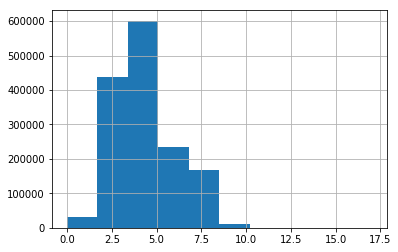

In [15]:
data.seq_name.apply(lambda x: len(x)).hist()

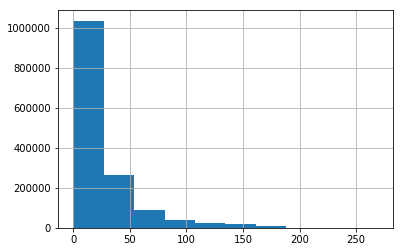

In [16]:
data.seq_item_description.apply(lambda x: len(x)).hist()

Vidimo da nam je dovoljno uzeti MAX_NAME_SEQ = 10 i MAX_ITEM_DESC_SEQ = 75

In [0]:
MAX_NAME_SEQ = 8
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(data.seq_name.max())
                   , np.max(test.seq_name.max())
                  , np.max(data.seq_item_description.max())
                  , np.max(test.seq_item_description.max())])+2
MAX_CAT1 = np.max([data.subcat1.max(), test.subcat1.max()])+1
MAX_CAT2 = np.max([data.subcat2.max(), test.subcat2.max()])+1
MAX_CAT3 = np.max([data.subcat3.max(), test.subcat3.max()])+1

MAX_BRAND = np.max([data.brand_name.max(), test.brand_name.max()])+1
MAX_CONDITION = np.max([data.item_condition_id.max(), test.item_condition_id.max()])+1

Scaleamo target varijablu

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f675d5e7780>]],
      dtype=object)

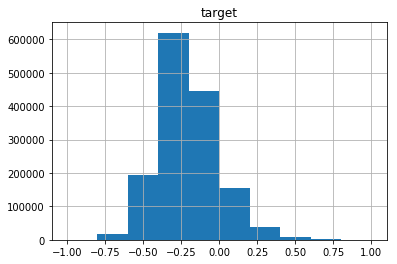

In [18]:
data["target"] = np.log(data.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
data["target"] = target_scaler.fit_transform(data.target.values.reshape(-1,1))
pd.DataFrame(data.target).hist()

In [19]:
dtrain, dvalid = train_test_split(data, random_state=42, train_size=0.95)
print(dtrain.shape)
print(dvalid.shape)

(1408408, 12)
(74127, 12)


In [0]:
#KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name)
        ,'subcat1': np.array(dataset.subcat1)
        ,'subcat2': np.array(dataset.subcat2)
        ,'subcat3': np.array(dataset.subcat3)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [0]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

### Modeli

In [0]:
def get_model():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_subcat1 = Embedding(MAX_CAT1, 10)(subcat1)
    emb_subcat2 = Embedding(MAX_CAT2, 10)(subcat2)
    emb_subcat3 = Embedding(MAX_CAT3, 10)(subcat3)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_subcat1)
        , Flatten() (emb_subcat2)
        , Flatten() (emb_subcat3)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()

In [0]:
dtrain.head()

,name,item_condition_id,brand_name,price,shipping,item_description,subcat1,subcat2,subcat3,seq_item_description,seq_name,target
train_id,,,,,,,,,,,,
407853,maroon velvet lisette shorts,1,737,22.0,1,brand new from brandy melville,10,5,706,"[16, 5, 43, 536, 587]","[836, 1038, 18025, 129]",-0.175509
748699,Benefit Roller Lash Mascara FULL SIZE,2,574,14.0,1,Benefit Roller Lash Mascara FULL SIZE in the c...,0,63,301,"[1232, 2593, 1292, 643, 152, 6, 7, 2, 48, 24, ...","[1232, 2593, 1292, 643, 152, 6]",-0.287907
320295,Holographic Ipsy Bag,2,5265,7.0,0,Used once,10,112,223,"[31, 96]","[2875, 2240, 101]",-0.453202
1094144,Samsung galaxy on5 10/10 con. W/metropcs,2,4121,40.0,1,No description yet,1,23,178,"[12, 68, 79]","[440, 438, 12298, 95, 95, 3901, 245, 11128]",-0.023501
1310650,Country Heat,2,5265,28.0,0,Comes with 4 DVDs and a bonus DVD. Also comes ...,1,65,240,"[103, 9, 47, 2354, 1, 4, 2205, 699, 154, 103, ...","[2215, 1160]",-0.114556


In [0]:
#FITTING THE MODEL
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Greške na training skupu nakon 5.epohe:
loss: 0.0146 - mean_absolute_error: 0.0914 - rmsle_cust: 0.0120 - val_loss: 0.0154 - val_mean_absolute_error: 0.0932 - val_rmsle_cust: 0.0125

Evaluiramo model na validacijskom skupu

In [0]:
#EVALUATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

 RMSLE na validacijskom: 0.4855084693671954


Idem isprobati malo drukčije:
smanjit ćemo batch size, staviti 5 epoha i dalje, dodati još jedan layer

In [0]:
def get_model1():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 64)(name)
    emb_item_desc = Embedding(MAX_TEXT, 64)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 16)(brand_name)
    emb_subcat1 = Embedding(MAX_CAT1, 16)(subcat1)
    emb_subcat2 = Embedding(MAX_CAT2, 16)(subcat2)
    emb_subcat3 = Embedding(MAX_CAT3, 16)(subcat3)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    rnn_layer3 = GRU(4)(emb_brand_name) 
    
    #main layer
    main_l = concatenate([
        rnn_layer3
        , Flatten() (emb_subcat1)
        , Flatten() (emb_subcat2)
        , Flatten() (emb_subcat3)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

In [0]:
model = get_model1()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
subcat1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
subcat2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
subcat3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
item_condi

In [0]:
#FITTING THE MODEL
BATCH_SIZE = 10000
epochs = 5

model = get_model1()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Train on 1408408 samples, validate on 74127 samples
Epoch 1/5
1408408/1408408 [==============================] - 370s 263us/step - loss: 0.0287 - mean_absolute_error: 0.1263 - rmsle_cust: 0.0161 - val_loss: 0.0175 - val_mean_absolute_error: 0.0999 - val_rmsle_cust: 0.0134
Epoch 2/5
1408408/1408408 [==============================] - 356s 253us/step - loss: 0.0174 - mean_absolute_error: 0.0997 - rmsle_cust: 0.0130 - val_loss: 0.0162 - val_mean_absolute_error: 0.0959 - val_rmsle_cust: 0.0129
Epoch 3/5
1408408/1408408 [==============================] - 362s 257us/step - loss: 0.0154 - mean_absolute_error: 0.0940 - rmsle_cust: 0.0123 - val_loss: 0.0153 - val_mean_absolute_error: 0.0933 - val_rmsle_cust: 0.0125
Epoch 4/5
1408408/1408408 [==============================] - 374s 265us/step - loss: 0.0143 - mean_absolute_error: 0.0903 - rmsle_cust: 0.0119 - val_loss: 0.0151 - val_mean_absolute_error: 0.0924 - val_rmsle_cust: 0.0123
Epoch 5/5
1408408/1408408 [==============================] - 364

Greške na training skupu: 
loss: 0.0133 - mean_absolute_error: 0.0868 - rmsle_cust: 0.0115 - val_loss: 0.0150 - val_mean_absolute_error: 0.0929 - val_rmsle_cust: 0.0122

In [0]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

 RMSLE na validacijskom: 0.47965386188750087


RMSLE na validacijskom: 0.4787711738282493

Ispalo je ponešto bolje. Što ako još smanjim batch size?

In [0]:
#FITTING THE MODEL
BATCH_SIZE = 5000
epochs = 5

model = get_model1()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Train on 1467709 samples, validate on 14826 samples
Epoch 1/5
1467709/1467709 [==============================] - 552s 376us/step - loss: 0.0206 - mean_absolute_error: 0.1081 - rmsle_cust: 0.0138 - val_loss: 0.0158 - val_mean_absolute_error: 0.0951 - val_rmsle_cust: 0.0126
Epoch 2/5
1467709/1467709 [==============================] - 548s 373us/step - loss: 0.0152 - mean_absolute_error: 0.0933 - rmsle_cust: 0.0123 - val_loss: 0.0152 - val_mean_absolute_error: 0.0940 - val_rmsle_cust: 0.0122
Epoch 3/5
1467709/1467709 [==============================] - 548s 373us/step - loss: 0.0141 - mean_absolute_error: 0.0894 - rmsle_cust: 0.0118 - val_loss: 0.0149 - val_mean_absolute_error: 0.0927 - val_rmsle_cust: 0.0123
Epoch 4/5
1467709/1467709 [==============================] - 547s 373us/step - loss: 0.0131 - mean_absolute_error: 0.0862 - rmsle_cust: 0.0114 - val_loss: 0.0148 - val_mean_absolute_error: 0.0921 - val_rmsle_cust: 0.0121
Epoch 5/5
1467709/1467709 [==============================] - 546

Greška na test skupu:
loss: 0.0123 - mean_absolute_error: 0.0834 - rmsle_cust: 0.0109 - val_loss: 0.0147 - val_mean_absolute_error: 0.0915 - val_rmsle_cust: 0.0120


In [0]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

 RMSLE na validacijskom: 0.4771689923714617


RMSLE na validacijskom: 0.4771689923714617

Što se dogodi ako ubacim još koji dropout?

In [0]:
def get_model2():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_subcat1 = Embedding(MAX_CAT1, 10)(subcat1)
    emb_subcat2 = Embedding(MAX_CAT2, 10)(subcat2)
    emb_subcat3 = Embedding(MAX_CAT3, 10)(subcat3)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_subcat1)
        , Flatten() (emb_subcat2)
        , Flatten() (emb_subcat3)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    
    main_l = Dropout(0.3)(Dense(512,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.3)(Dense(256,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.3)(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.3)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))

    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model2()
model.summary()

In [0]:
#FITTING THE MODEL
BATCH_SIZE = 10000
epochs = 5

model = get_model2()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Train on 1467709 samples, validate on 14826 samples
Epoch 1/5
1467709/1467709 [==============================] - 438s 298us/step - loss: 0.0261 - mean_absolute_error: 0.1224 - rmsle_cust: 0.0163 - val_loss: 0.0186 - val_mean_absolute_error: 0.1035 - val_rmsle_cust: 0.0161
Epoch 2/5
1467709/1467709 [==============================] - 427s 291us/step - loss: 0.0184 - mean_absolute_error: 0.1022 - rmsle_cust: 0.0161 - val_loss: 0.0172 - val_mean_absolute_error: 0.0995 - val_rmsle_cust: 0.0155
Epoch 3/5
1467709/1467709 [==============================] - 419s 286us/step - loss: 0.0170 - mean_absolute_error: 0.0979 - rmsle_cust: 0.0153 - val_loss: 0.0157 - val_mean_absolute_error: 0.0938 - val_rmsle_cust: 0.0149
Epoch 4/5
1467709/1467709 [==============================] - 428s 292us/step - loss: 0.0159 - mean_absolute_error: 0.0947 - rmsle_cust: 0.0146 - val_loss: 0.0153 - val_mean_absolute_error: 0.0923 - val_rmsle_cust: 0.0143
Epoch 5/5
1467709/1467709 [==============================] - 426

Greška na training skupu: 
loss: 0.0151 - mean_absolute_error: 0.0924 - rmsle_cust: 0.0140 - val_loss: 0.0149 - val_mean_absolute_error: 0.0904 - val_rmsle_cust: 0.0140

In [0]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

 RMSLE na validacijskom: 0.4781637090029327


 RMSLE na validacijskom: 0.4781637090029327


Ako ubacimo još koji dropuot, ostaje otprilike isti rezultat, a vrijeme je jednako veliko

Ako povećamo embedding faktore, što će se dogoditi?

In [0]:
def get_model4():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 128)(name)
    emb_item_desc = Embedding(MAX_TEXT, 64)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 64)(brand_name)
    emb_subcat1 = Embedding(MAX_CAT1, 32)(subcat1)
    emb_subcat2 = Embedding(MAX_CAT2, 32)(subcat2)
    emb_subcat3 = Embedding(MAX_CAT3, 32)(subcat3)
    emb_item_condition = Embedding(MAX_CONDITION, 8)(item_condition)
    
    #rnn layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
    rnn_layer3 = GRU(4)(emb_brand_name) 
    
    #main layer
    main_l = concatenate([
        rnn_layer3
        , Flatten() (emb_subcat1)
        , Flatten() (emb_subcat2)
        , Flatten() (emb_subcat3)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model
  
model = get_model4()
model.summary()

In [0]:
#FITTING THE MODEL
BATCH_SIZE = 10000
epochs = 10

model = get_model4()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Train on 1467709 samples, validate on 14826 samples
Epoch 1/10
1467709/1467709 [==============================] - 458s 312us/step - loss: 0.0228 - mean_absolute_error: 0.1140 - rmsle_cust: 0.0143 - val_loss: 0.0164 - val_mean_absolute_error: 0.0972 - val_rmsle_cust: 0.0128
Epoch 2/10
1467709/1467709 [==============================] - 449s 306us/step - loss: 0.0160 - mean_absolute_error: 0.0956 - rmsle_cust: 0.0126 - val_loss: 0.0153 - val_mean_absolute_error: 0.0940 - val_rmsle_cust: 0.0124
Epoch 3/10
1467709/1467709 [==============================] - 453s 309us/step - loss: 0.0147 - mean_absolute_error: 0.0917 - rmsle_cust: 0.0121 - val_loss: 0.0151 - val_mean_absolute_error: 0.0935 - val_rmsle_cust: 0.0123
Epoch 4/10
1467709/1467709 [==============================] - 455s 310us/step - loss: 0.0139 - mean_absolute_error: 0.0890 - rmsle_cust: 0.0117 - val_loss: 0.0149 - val_mean_absolute_error: 0.0930 - val_rmsle_cust: 0.0121
Epoch 5/10
1467709/1467709 [==============================] 

Greška na training skupu: loss: 0.0130 - mean_absolute_error: 0.0860 - rmsle_cust: 0.0113 - val_loss: 0.0146 - val_mean_absolute_error: 0.0916 - val_rmsle_cust: 0.0120

In [0]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

 RMSLE na validacijskom: 0.4809565860698974


Nakon 5 epoha: RMSLE na validacijskom: 0.474487655036319

Nakon 10 epoha:  RMSLE na validacijskom: 0.4809565860698974 
pogorša se!


Dodajemo nekoliko dense layera s aktivacijom relu

In [30]:
def get_model5():    
    # Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")

    # Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 60)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_subcat1 = Embedding(MAX_CAT1, 10)(subcat1)
    emb_subcat2 = Embedding(MAX_CAT2, 10)(subcat2)
    emb_subcat3 = Embedding(MAX_CAT3, 10)(subcat3)
    
    # rnn layers
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)

    # main layers
    main_l = concatenate([
        Flatten() (emb_brand_name),
        Flatten() (emb_subcat1),
        Flatten() (emb_subcat2),
        Flatten() (emb_subcat3),
        item_condition,
        rnn_layer1,
        rnn_layer2,
        num_vars,
    ])

    main_l = Dense(256)(main_l)
    main_l = Activation('elu')(main_l)

    main_l = Dense(128)(main_l)
    main_l = Activation('elu')(main_l)

    main_l = Dense(64)(main_l)
    main_l = Activation('elu')(main_l)

    # the output layer.
    output = Dense(1, activation="linear") (main_l)

    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)

    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])


    return model

model = get_model5()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
subcat1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
subcat2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
subcat3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
item_desc 

In [33]:
#FITTING THE MODEL
BATCH_SIZE = 10000
epochs = 10

model = get_model5()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Train on 1408408 samples, validate on 74127 samples
Epoch 1/10
1408408/1408408 [==============================] - 367s 261us/step - loss: 0.0313 - mean_absolute_error: 0.1281 - rmsle_cust: 0.0172 - val_loss: 0.0172 - val_mean_absolute_error: 0.0986 - val_rmsle_cust: 0.0134
Epoch 2/10
1408408/1408408 [==============================] - 363s 258us/step - loss: 0.0156 - mean_absolute_error: 0.0937 - rmsle_cust: 0.0126 - val_loss: 0.0153 - val_mean_absolute_error: 0.0929 - val_rmsle_cust: 0.0126
Epoch 3/10
1408408/1408408 [==============================] - 360s 255us/step - loss: 0.0140 - mean_absolute_error: 0.0890 - rmsle_cust: 0.0119 - val_loss: 0.0150 - val_mean_absolute_error: 0.0916 - val_rmsle_cust: 0.0123
Epoch 4/10
1408408/1408408 [==============================] - 360s 255us/step - loss: 0.0131 - mean_absolute_error: 0.0861 - rmsle_cust: 0.0114 - val_loss: 0.0146 - val_mean_absolute_error: 0.0906 - val_rmsle_cust: 0.0121
Epoch 5/10
1408408/1408408 [==============================] 

In [34]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

 RMSLE na validacijskom: 0.46906979665411985


nakon 5 epoha:  RMSLE na validacijskom: 0.4708457943897959

nakon 10 epoha:  RMSLE na validacijskom: 0.46906979665411985



In [0]:
#FITTING THE MODEL
BATCH_SIZE = 1000
epochs = 5

model = get_model5()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

In [0]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

 RMSLE na validacijskom: 0.46891520472053166

Zašto ne isprobati dodavanje još kojeg sloja, možda s nekom drugom aktivacijskom funkcijom?

# Najbolji model za sad!

In [26]:
def get_model6():    
    # Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")

    # Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 60)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_subcat1 = Embedding(MAX_CAT1, 10)(subcat1)
    emb_subcat2 = Embedding(MAX_CAT2, 10)(subcat2)
    emb_subcat3 = Embedding(MAX_CAT3, 10)(subcat3)
    
    # rnn layers
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)

    # main layers
    main_l = concatenate([
        Flatten() (emb_brand_name),
        Flatten() (emb_subcat1),
        Flatten() (emb_subcat2),
        Flatten() (emb_subcat3),
        item_condition,
        rnn_layer1,
        rnn_layer2,
        num_vars,
    ])
    
    main_l = Dense(512)(main_l)
    main_l = Activation('relu')(main_l)
    
    main_l = Dense(256)(main_l)
    main_l = Activation('relu')(main_l)

    main_l = Dense(128)(main_l)
    main_l = Activation('relu')(main_l)

    main_l = Dense(64)(main_l)
    main_l = Activation('relu')(main_l)

    # the output layer.
    output = Dense(1, activation="linear") (main_l)

    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)

    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])


    return model

model = get_model6()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
subcat1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
subcat2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
subcat3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
item_desc 

In [0]:
#FITTING THE MODEL
BATCH_SIZE = 1000
epochs = 5

model = get_model6()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

In [0]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

Prvotno su išle aktivacijske funkcije redom: sigmoid, tanh, relu, relu.

Nakon 5 epoha: RMSLE na validacijskom: 0.4766091084883943
 
 Nakon 4 epohe:  RMSLE na validacijskom: 0.46666912700339036
 
 Ako stavim sve aktivacijske funkcije da budu 'relu'
 
 Nakon 4 epohe:  RMSLE na validacijskom: 0.4488953920679439
 
 Nakon 5 epoha:  RMSLE na validacijskom: 0.442122862243461

## CNN

In [0]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, Conv1D, GlobalMaxPooling1D, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K


def get_model7():
    #params
    dr_r = 0.5
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[1], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 50)(brand_name)
    emb_subcat_1 = Embedding(MAX_CAT1, 10)(subcat1)
    emb_subcat_2 = Embedding(MAX_CAT2, 20)(subcat2)
    emb_subcat_3 = Embedding(MAX_CAT3, 30)(subcat3)

 
    #rnn layer
    cnn_layer1 = Conv1D(filters=16, kernel_size=3, activation='relu') (emb_item_desc)
    cnn_layer2 = Conv1D(filters=8, kernel_size=3, activation='relu')(emb_name)
    
    cnn_layer1 = GlobalMaxPooling1D()(cnn_layer1)
    cnn_layer2 = GlobalMaxPooling1D()(cnn_layer2)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_subcat_1)
        , Flatten() (emb_subcat_2)
        , Flatten() (emb_subcat_3)
        , cnn_layer1
        , cnn_layer2
        , num_vars
        , item_condition
    ])
    
    main_l = Dropout(dr_r) (Dense(256, activation="relu") (main_l))
    main_l = Dropout(dr_r) (Dense(128, activation="relu") (main_l))
    main_l = Dropout(dr_r) (Dense(64, activation="relu") (main_l))
    
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)
    
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model7()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_desc (InputLayer)          (None, 75)           0                                            
__________________________________________________________________________________________________
name (InputLayer)               (None, 10)           0                                            
__________________________________________________________________________________________________
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
subcat1 (InputLayer) 

In [0]:
#FITTING THE MODEL
BATCH_SIZE = 10000
epochs = 15

model = get_model7()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Train on 1467709 samples, validate on 14826 samples
Epoch 1/15
1467709/1467709 [==============================] - 238s 162us/step - loss: 0.0322 - mean_absolute_error: 0.1368 - rmsle_cust: 0.0165 - val_loss: 0.0193 - val_mean_absolute_error: 0.1087 - val_rmsle_cust: 0.0139
Epoch 2/15
1467709/1467709 [==============================] - 235s 160us/step - loss: 0.0181 - mean_absolute_error: 0.1024 - rmsle_cust: 0.0138 - val_loss: 0.0165 - val_mean_absolute_error: 0.0978 - val_rmsle_cust: 0.0143
Epoch 3/15
1467709/1467709 [==============================] - 236s 160us/step - loss: 0.0156 - mean_absolute_error: 0.0947 - rmsle_cust: 0.0130 - val_loss: 0.0156 - val_mean_absolute_error: 0.0952 - val_rmsle_cust: 0.0138
Epoch 4/15
1467709/1467709 [==============================] - 236s 161us/step - loss: 0.0141 - mean_absolute_error: 0.0901 - rmsle_cust: 0.0126 - val_loss: 0.0152 - val_mean_absolute_error: 0.0934 - val_rmsle_cust: 0.0135
Epoch 5/15
1467709/1467709 [==============================] 

In [0]:
#EVALUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

 RMSLE na validacijskom: 0.48178611835213986


Nakon 15 epoha:  RMSLE na validacijskom: 0.48178611835213986

Nakon 10 epoha:  RMSLE na validacijskom: 0.4927266404259878

Nakon 5 epoha:  RMSLE na validacijskom: 0.5118675884280706

Ako promijenim broj filtera na cnn_layer2 a 16

In [0]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, Conv1D, GlobalMaxPooling1D, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K


def get_model8():
    #params
    dr_r = 0.5
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[1], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 50)(brand_name)
    emb_subcat_1 = Embedding(MAX_CAT1, 10)(subcat1)
    emb_subcat_2 = Embedding(MAX_CAT2, 20)(subcat2)
    emb_subcat_3 = Embedding(MAX_CAT3, 30)(subcat3)

 
    #rnn layer
    cnn_layer1 = Conv1D(filters=16, kernel_size=3, activation='relu') (emb_item_desc)
    cnn_layer2 = Conv1D(filters=16, kernel_size=3, activation='relu')(emb_name)
    
    cnn_layer1 = GlobalMaxPooling1D()(cnn_layer1)
    cnn_layer2 = GlobalMaxPooling1D()(cnn_layer2)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_subcat_1)
        , Flatten() (emb_subcat_2)
        , Flatten() (emb_subcat_3)
        , cnn_layer1
        , cnn_layer2
        , num_vars
        , item_condition
    ])
    
    main_l = Dropout(dr_r) (Dense(256, activation="relu") (main_l))
    main_l = Dropout(dr_r) (Dense(128, activation="relu") (main_l))
    main_l = Dropout(dr_r) (Dense(64, activation="relu") (main_l))
    
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)
    
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model8()
model.summary()

In [0]:
#FITTING THE MODEL
BATCH_SIZE = 10000
epochs = 10

model = get_model8()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

In [0]:
#EVALUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

 RMSLE na validacijskom: 0.48348509735603296


5 epoha: 0.49018418646992745


10 epoha:  RMSLE na validacijskom: 0.48348509735603296




Povećavam kernel size pri kreiranju cnn layera

In [0]:
def get_model9():
    #params
    dr_r = 0.5
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[1], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 50)(brand_name)
    emb_subcat_1 = Embedding(MAX_CAT1, 10)(subcat1)
    emb_subcat_2 = Embedding(MAX_CAT2, 20)(subcat2)
    emb_subcat_3 = Embedding(MAX_CAT3, 30)(subcat3)

 
    #rnn layer
    cnn_layer1 = Conv1D(filters=16, kernel_size=5, activation='relu') (emb_item_desc)
    cnn_layer2 = Conv1D(filters=16, kernel_size=5, activation='relu')(emb_name)
    
    cnn_layer1 = GlobalMaxPooling1D()(cnn_layer1)
    cnn_layer2 = GlobalMaxPooling1D()(cnn_layer2)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_subcat_1)
        , Flatten() (emb_subcat_2)
        , Flatten() (emb_subcat_3)
        , cnn_layer1
        , cnn_layer2
        , num_vars
        , item_condition
    ])
    
    main_l = Dropout(dr_r) (Dense(256, activation="relu") (main_l))
    main_l = Dropout(dr_r) (Dense(128, activation="relu") (main_l))
    main_l = Dropout(dr_r) (Dense(64, activation="relu") (main_l))
    
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)
    
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model9()
model.summary()

In [0]:
#FITTING THE MODEL
BATCH_SIZE = 10000
epochs = 15

model = get_model9()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Nakon 5 epoha:  RMSLE na validacijskom: 0.49636820125708847

Nakon 15 epoha:  RMSLE na validacijskom: 0.4859954799040339

Ne dobijem ništa od povećavanja kernel size-a, odustajem.


Dodajem regularizers

In [21]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, Conv1D, GlobalMaxPooling1D, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
from keras import regularizers

def get_model10():
    #params
    dr_r = 0.5
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[1], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 50)(brand_name)
    emb_subcat_1 = Embedding(MAX_CAT1, 10)(subcat1)
    emb_subcat_2 = Embedding(MAX_CAT2, 20)(subcat2)
    emb_subcat_3 = Embedding(MAX_CAT3, 30)(subcat3)

 
    #rnn layer
    cnn_layer1 = Conv1D(filters=16, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(0.01)) (emb_item_desc)
    cnn_layer2 = Conv1D(filters=16, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_name)
    
    cnn_layer1 = GlobalMaxPooling1D()(cnn_layer1)
    cnn_layer2 = GlobalMaxPooling1D()(cnn_layer2)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_subcat_1)
        , Flatten() (emb_subcat_2)
        , Flatten() (emb_subcat_3)
        , cnn_layer1
        , cnn_layer2
        , num_vars
        , item_condition
    ])
    
    main_l = Dropout(dr_r) (Dense(256, activation="relu") (main_l))
    main_l = Dropout(dr_r) (Dense(128, activation="relu") (main_l))
    main_l = Dropout(dr_r) (Dense(64, activation="relu") (main_l))
    
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)
    
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model10()
model.summary()

W0618 15:03:05.771106 139898051307392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 15:03:05.795740 139898051307392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 15:03:05.797505 139898051307392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 15:03:05.956928 139898051307392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0618 15:03:05.969228 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_desc (InputLayer)          (None, 75)           0                                            
__________________________________________________________________________________________________
name (InputLayer)               (None, 8)            0                                            
__________________________________________________________________________________________________
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
subcat1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
subcat2 (I

In [24]:
#FITTING THE MODEL
BATCH_SIZE = 10000
epochs = 5

model = get_model10()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Train on 1408408 samples, validate on 74127 samples
Epoch 1/5
1408408/1408408 [==============================] - 199s 141us/step - loss: 0.2008 - mean_absolute_error: 0.1404 - rmsle_cust: 0.0168 - val_loss: 0.0475 - val_mean_absolute_error: 0.1162 - val_rmsle_cust: 0.0150
Epoch 2/5
1408408/1408408 [==============================] - 195s 139us/step - loss: 0.0277 - mean_absolute_error: 0.1087 - rmsle_cust: 0.0146 - val_loss: 0.0179 - val_mean_absolute_error: 0.0987 - val_rmsle_cust: 0.0137
Epoch 3/5
1408408/1408408 [==============================] - 197s 140us/step - loss: 0.0184 - mean_absolute_error: 0.1014 - rmsle_cust: 0.0139 - val_loss: 0.0162 - val_mean_absolute_error: 0.0944 - val_rmsle_cust: 0.0134
Epoch 4/5
1408408/1408408 [==============================] - 193s 137us/step - loss: 0.0170 - mean_absolute_error: 0.0977 - rmsle_cust: 0.0135 - val_loss: 0.0155 - val_mean_absolute_error: 0.0931 - val_rmsle_cust: 0.0128
Epoch 5/5
1408408/1408408 [==============================] - 196

In [25]:
#EVALUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

 RMSLE na validacijskom: 0.4863006604782542


5 epoha: RMSLE na validacijskom: 0.4838138394894774

10 epoha: RMSLE na validacijskom: 0.4786297305794245

15 epoha:  RMSLE na validacijskom: 0.4711620291410097

20 epoha:  RMSLE na validacijskom: 0.47936733148934196



In [36]:
#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, Conv1D, GlobalMaxPooling1D, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
from keras import regularizers

def get_model11():
    #params
    dr_r = 0.5
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[1], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 64)(name)
    emb_item_desc = Embedding(MAX_TEXT, 64)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 64)(brand_name)
    emb_subcat_1 = Embedding(MAX_CAT1, 10)(subcat1)
    emb_subcat_2 = Embedding(MAX_CAT2, 20)(subcat2)
    emb_subcat_3 = Embedding(MAX_CAT3, 30)(subcat3)

 
    #rnn layer
    cnn_layer1 = Conv1D(filters=16, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(0.01)) (emb_item_desc)
    cnn_layer2 = Conv1D(filters=16, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_name)
    
    cnn_layer1 = GlobalMaxPooling1D()(cnn_layer1)
    cnn_layer2 = GlobalMaxPooling1D()(cnn_layer2)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_subcat_1)
        , Flatten() (emb_subcat_2)
        , Flatten() (emb_subcat_3)
        , cnn_layer1
        , cnn_layer2
        , num_vars
        , item_condition
    ])
    
    main_l = Dropout(dr_r) (Dense(256, activation="relu") (main_l))
    main_l = Dropout(dr_r) (Dense(128, activation="relu") (main_l))
    main_l = Dropout(dr_r) (Dense(64, activation="relu") (main_l))
    
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)
    
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model11()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_desc (InputLayer)          (None, 75)           0                                            
__________________________________________________________________________________________________
name (InputLayer)               (None, 8)            0                                            
__________________________________________________________________________________________________
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
subcat1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
subcat2 (I

In [37]:
#FITTING THE MODEL
BATCH_SIZE = 10000
epochs = 5

model = get_model11()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Train on 1408408 samples, validate on 74127 samples
Epoch 1/5
1408408/1408408 [==============================] - 232s 165us/step - loss: 0.1979 - mean_absolute_error: 0.1469 - rmsle_cust: 0.0173 - val_loss: 0.0428 - val_mean_absolute_error: 0.1240 - val_rmsle_cust: 0.0154
Epoch 2/5
1408408/1408408 [==============================] - 230s 164us/step - loss: 0.0264 - mean_absolute_error: 0.1124 - rmsle_cust: 0.0148 - val_loss: 0.0185 - val_mean_absolute_error: 0.1022 - val_rmsle_cust: 0.0142
Epoch 3/5
1408408/1408408 [==============================] - 230s 163us/step - loss: 0.0190 - mean_absolute_error: 0.1037 - rmsle_cust: 0.0140 - val_loss: 0.0167 - val_mean_absolute_error: 0.0971 - val_rmsle_cust: 0.0136
Epoch 4/5
1408408/1408408 [==============================] - 227s 161us/step - loss: 0.0175 - mean_absolute_error: 0.0995 - rmsle_cust: 0.0136 - val_loss: 0.0165 - val_mean_absolute_error: 0.0973 - val_rmsle_cust: 0.0132
Epoch 5/5
1408408/1408408 [==============================] - 226

In [38]:
#EVALUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

 RMSLE na validacijskom: 0.4877910134982936


S povećanim koeficijentima embeddinga, ista cnn daje sljedeće rezultate:

Nakon 5 epoha: RMSLE na validacijskom: 0.47676170497333076
 tj veći nego prije.

In [23]:

#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, Conv1D, GlobalMaxPooling1D, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
from keras import regularizers

def get_model12():    
    # Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    subcat1 = Input(shape=[1], name="subcat1")
    subcat2 = Input(shape=[1], name="subcat2")
    subcat3 = Input(shape=[1], name="subcat3")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")

    # Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 60)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_subcat1 = Embedding(MAX_CAT1, 10)(subcat1)
    emb_subcat2 = Embedding(MAX_CAT2, 10)(subcat2)
    emb_subcat3 = Embedding(MAX_CAT3, 10)(subcat3)
    
    cnn_layer1 = Conv1D(filters=16, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(0.01)) (emb_item_desc)
    cnn_layer2 = Conv1D(filters=16, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(0.01))(emb_name)
    
    cnn_layer1 = GlobalMaxPooling1D()(cnn_layer1)
    cnn_layer2 = GlobalMaxPooling1D()(cnn_layer2)

    # main layers
    main_l = concatenate([
        Flatten() (emb_brand_name),
        Flatten() (emb_subcat1),
        Flatten() (emb_subcat2),
        Flatten() (emb_subcat3),
        item_condition,
        cnn_layer1,
        cnn_layer2,
        num_vars,
    ])
    
    main_l = Dense(512)(main_l)
    main_l = Activation('relu')(main_l)
    
    main_l = Dense(256)(main_l)
    main_l = Activation('relu')(main_l)

    main_l = Dense(128)(main_l)
    main_l = Activation('relu')(main_l)

    main_l = Dense(64)(main_l)
    main_l = Activation('relu')(main_l)

    # the output layer.
    output = Dense(1, activation="linear") (main_l)

    model = Model([name, item_desc, brand_name, subcat1, subcat2, subcat3, item_condition, num_vars], output)

    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])


    return model

model = get_model12()
model.summary()

W0618 20:38:25.536352 140084485093248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0618 20:38:25.578406 140084485093248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_desc (InputLayer)          (None, 75)           0                                            
__________________________________________________________________________________________________
name (InputLayer)               (None, 8)            0                                            
__________________________________________________________________________________________________
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
subcat1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
subcat2 (I

In [0]:
#FITTING THE MODEL
BATCH_SIZE = 10000
epochs = 5

model = get_model12()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

In [0]:
#EVALUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

Nakon 5 epoha:  RMSLE na validacijskom: 0.45740166297725926


## Word2vec

In [0]:
from gensim.models import word2vec
import re
sentences = [s for s in [s.strip().lower().split(" ") for i in data["item_description"].values for s in re.split("\.", str(i))] if len(s) > 2]
embedding_size = 300
starttime = time.time()
model = word2vec.Word2Vec(sentences, size=embedding_size, window=5, min_count=5, workers=4)
endtime = time.time()
print("Trained word2vec model in " + str(int(np.floor((endtime - starttime)/60))) + "m " + str(int((endtime - starttime)%60)) + "s.")

# Get the embeddings into a matrix
embedding_matrix = np.zeros((len(model.wv.index2word), embedding_size))
for i in range(0, len(model.wv.index2word)):
    w = model.wv.index2word[i]
    embedding_matrix[i] = model.wv[w]


Trained word2vec model in 7m 43s.


In [0]:
embedding_matrix.shape

(99843, 300)

In [0]:
import keras
def truncated_normal(seed):
    return keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=seed)

In [0]:
# create cnn model
from keras.layers import Embedding, Dense, Input, Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D, Concatenate, Dropout
from keras.models import Model
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=20) #20 najčešćih riječi

# parameters
input_length = pad_sequences(tokenizer.texts_to_sequences(data['item_description'].astype(str).tolist())).shape[1] # len (num words) of longest description
seed = 0
filter_sizes = [2,3]
n_filters = 2
dropout_prob = 0.5
EMBEDDING_DIM=300

def create_cnn(include_top=True, weights=None):    

    # input
    sequence_input = Input(shape=(input_length,), dtype='int32', name='input')
    # embedding_layer
    embedding_layer = Embedding(99843, EMBEDDING_DIM, weights=[embedding_matrix], input_length=input_length
                                , name='embedding', trainable=False)(sequence_input)
    # conv layer
    features = []
    i = 0
    for filter_size in filter_sizes:
        i += 1
        # conv layer
        conv = Conv1D(n_filters, filter_size, activation='relu', kernel_initializer=truncated_normal(seed)
                      , name='conv'+str(i))(embedding_layer)
        # global max pooling
        conv = GlobalMaxPooling1D(name='pool'+str(i))(conv)
        # add features together
        features.append(conv)
    # penultimate layer
    nn = Concatenate(name='features')(features)
    if include_top:
        # dropout
        nn = Dropout(dropout_prob, seed=seed, name='dropout')(nn)
        # fully connected layer
        preds = Dense(1, kernel_initializer=truncated_normal(seed), name='output')(nn)

        model = Model(sequence_input, preds)
    else:
        model = Model(sequence_input, nn)
    
    
    if weights is not None:
        model.set_weights(weights)
        
    return model

In [0]:
model = create_cnn()
model.summary()

ValueError: ignored

In [0]:
#EVALUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE na validacijskom: "+str(v_rmsle))

## Word2vec pokusaj 2

https://blog.cambridgespark.com/tutorial-build-your-own-embedding-and-use-it-in-a-neural-network-e9cde4a81296

 Potrebno je downloadati  ‘brown’ i ‘conll2000’ 

In [0]:
import nltk
nltk.download()
from nltk.corpus import brown
from gensim.models import word2vec
import multiprocessing

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> brown
      Package brown is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> conll2000
      Package conll2000 is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [0]:
sentences=brown.sents()
print(sentences[:3])

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ['The', 'September-October', 'term', 'jury', 'had', 'been', 'charged', 'by', 'Fulton', 'Superior', 'Court', 'Judge', 'Durwood', 'Pye', 'to', 'investigate', 'reports', 'of', 'possible', '``', 'irregularities', "''", 'in', 'the', 'hard-fought', 'primary', 'which', 'was', 'won', 'by', 'Mayor-nominate', 'Ivan', 'Allen', 'Jr.', '.']]


In [0]:
EMB_DIM=300
w2v= Word2Vec(sentences, size=EMB_DIM, window=5, min_count=5, negative=15, iter=10, workers=multiprocessing.cpu_count())


In [0]:
word_vectors=w2v.wv
result=word_vectors.similar_by_word("Saturday")
print("Most similar word", result[:3])

Most similar word [('Monday', 0.8954941630363464), ('Sunday', 0.8876497745513916), ('Friday', 0.8775694370269775)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
list=dtrain['item_description'].astype(str).tolist()
list


In [0]:
import re #za regularne izraze
sentences = [s for s in [s.strip().lower().split(" ") for i in dtrain["item_description"].values for s in re.split("\.", str(i))] if len(s) > 2]

In [0]:
embedding_size = 300
starttime = time.time()
model = word2vec.Word2Vec(sentences, size=embedding_size, window=5, min_count=5, workers=4)
endtime = time.time()
print("Trained word2vec model in " + str(int(np.floor((endtime - starttime)/60))) + "m " + str(int((endtime - starttime)%60)) + "s.")

Trained word2vec model in 7m 41s.


In [0]:
# First get the embeddings into a matrix
embeddings = np.zeros((len(model.wv.index2word), embedding_size))
for i in range(0, len(model.wv.index2word)):
    w = model.wv.index2word[i]
    embeddings[i] = model.wv[w]

# Look at a few samples
for i in range(1000, 1003):
    print(model.wv.index2word[i] + ":\n" + str(embeddings[i]))

brands:
[ 0.44668913  1.00813818 -0.22744668 -0.9685902  -3.41443086 -3.16814089
 -0.22257502 -0.03917033 -1.22988534  2.18945885 -2.84362912 -0.19964619
 -1.58515918  1.42916739 -3.25213361 -0.23979598 -0.2544238  -1.33195376
 -0.42963734 -0.7462576   0.07675014 -2.65952826 -0.24966502  1.64022124
  0.86781543  2.54823875 -1.04541171  1.30657816 -0.19551505 -3.35859537
  2.30055141  0.33194959 -0.98279977 -1.50124264  2.85995841  1.21530592
  0.641653   -1.72203624  3.25559616  1.94765139  0.93429691 -2.79589486
  0.42177838  0.43948707 -2.44652176  1.93160319 -0.3613373  -1.74829733
 -0.16010456 -0.11765492  0.86090881 -0.98350197 -0.10672019 -0.05587982
 -1.39775884  1.96347141 -1.01379275 -3.33755255 -0.76610672 -0.12707937
 -1.07743227  0.20845501  0.20666289 -0.21156941 -2.97382569  0.17074463
 -1.6924746  -1.07575905 -1.46513724 -0.47477415 -2.75424218  0.16317828
 -1.61430883 -2.18920207 -1.12000692  1.45951211  0.5928722  -0.8480345
  2.01112962  0.46623895 -1.7516222  -1.5405

In [0]:
embeddings.shape

(96933, 300)

Za vizualizaciju

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=500, random_state=101)
embeddings_2d_projection = svd.fit_transform(embeddings)
embeddings_2d_projection.shape

(96933, 2)

In [0]:
lookup_words = ["shorts", "xbox", "shoes"]
words_to_visualize = [] # Save for visualization below

for w in lookup_words:
    print(w)
    for s in model.wv.most_similar([w]):
        print(s)
        words_to_visualize.append(s[0])

shorts
('shorts!', 0.77289879322052)
('capris', 0.7676331400871277)
('shorts,', 0.7595573663711548)
('pants', 0.7148447036743164)
('skort', 0.6574950218200684)
('overalls', 0.656518280506134)
('shorts-', 0.6516613960266113)
('joggers', 0.6134329438209534)
("capri's", 0.6130681037902832)
('shorts)', 0.6072177290916443)
xbox
('ps4', 0.6656961441040039)
('ps3', 0.6522459983825684)
('x-box', 0.6271170973777771)
('-xbox', 0.6259353160858154)
('playstation', 0.5802122354507446)
('ps4,', 0.5763287544250488)
('controller,', 0.5707730054855347)
('sony', 0.5601280927658081)
('battlefield', 0.5365286469459534)
('xboxone', 0.5357046127319336)
shoes
('sneakers', 0.8067567348480225)
('shoes!', 0.7545838356018066)
('shoe', 0.6472645998001099)
('sneaker', 0.6412380337715149)
('shoes,', 0.6370909214019775)
('sandals', 0.6274315118789673)
('flats', 0.6270042657852173)
('loafers', 0.6198732256889343)
('boots', 0.5915223956108093)
('sperrys', 0.5893703699111938)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


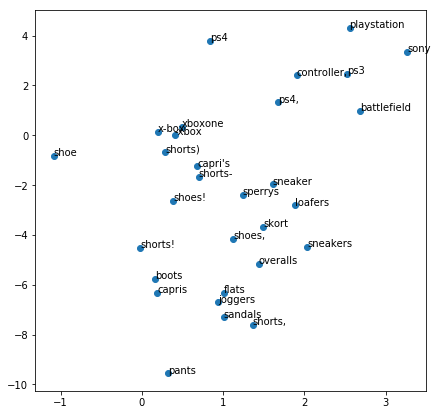

In [0]:
sample = np.in1d(model.wv.index2word, words_to_visualize)
x = embeddings_2d_projection[sample,0]
y = embeddings_2d_projection[sample,1]
plt.figure(figsize=(7,7))
plt.scatter(x, y)
for i, txt in enumerate([model.wv.index2word[i] for i in np.where(sample)[0]]):
    plt.annotate(txt, (x[i], y[i]))

## Word2Vec pokušaj tri

Slijedim https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [0]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
from gensim.models.phrases import Phrases, Phraser

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [0]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [0]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in dtrain['item_description'])
#brief_cleaning_valid = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in dvalid['item_description'])
#brief_cleaning_test = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in test['item_description'])

In [29]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
#txt_valid = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_valid, batch_size=5000, n_threads=-1)]
#txt_test = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_test, batch_size=5000, n_threads=-1)]


print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 29.12 mins


In [30]:
data_clean = pd.DataFrame({'clean': txt})
#valid_clean = pd.DataFrame({'clean': txt_valid})
#test_clean = pd.DataFrame({'clean': txt_test})

data_clean = data_clean.dropna().drop_duplicates()
#valid_clean = valid_clean.dropna().drop_duplicates()
#test_clean = test_clean.dropna().drop_duplicates()

data_clean.shape

(1133921, 1)

In [0]:
from gensim.models.phrases import Phrases, Phraser

#uzima listu riječi kao input i kreira relevantne fraze iz liste rečenica

data_sent = [row.split() for row in data_clean['clean']]
#valid_sent = [row.split() for row in valid_clean['clean']]
#test_sent = [row.split() for row in test_clean['clean']]

phrases = Phrases(data_sent, min_count=30, progress_per=10000)
#valid_phrases = Phrases(valid_sent, min_count=30, progress_per=10000)
#test_phrases = Phrases(test_sent, min_count=30, progress_per=10000)

U ovoj ćeliji spremam phrases za poslije

In [0]:
import pickle

# Store data (serialize)
with open('phrases.pickle', 'wb') as handle:
    pickle.dump(phrases, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('datasent.pickle', 'wb') as handle:
    pickle.dump(data_sent, handle, protocol=pickle.HIGHEST_PROTOCOL)

Iduća ćelija je za loadanje phrases

In [0]:
import pickle
# Load data (deserialize)
with open('phrases.pickle', 'rb') as handle:
    phrases = pickle.load(handle)
with open('datasent.pickle', 'rb') as handle:
    data_sent = pickle.load(handle)

In [0]:
bigram = Phraser(phrases)

In [0]:
sentences = bigram[data_sent]
#valid_sentences = bigram[valid_sent]
#test_sentences = bigram[test_sent]

In [29]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

121578

In [30]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['size',
 'new',
 'wear',
 'brand',
 'condition',
 'free',
 'shipping',
 'rm',
 'color',
 'black']

In [0]:
import multiprocessing

from gensim.models import Word2Vec

In [0]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

**Parametri**

min_count ->ignorira sve riječi kojih ima manje od min_count

window-> maksimalna udaljenost između trenutne i predviđene riječi u rečenici.

size->dimenzije feature vektora

sample-> jako utjecajan parametar-> treshold za konfiguraciju koje visokofrekventne riječi budu downsamplane.

alpha->learning rate, ne sjećam se više kako to prevodimo lol

min_alpha->očito

negative-> ako je >0, koristit će se negativno uzorkovanje

workers->koliko threadova za treniranje modela

In [0]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [34]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 1.14 mins


In [35]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=10, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 19.19 mins


In [0]:
w2v_model.init_sims(replace=True)

In [37]:
w2v_model.wv.most_similar(positive=["necklace"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bracelet', 0.724303126335144),
 ('pendant_necklace', 0.7080237865447998),
 ('earring', 0.6951838135719299),
 ('necklace_pendant', 0.675955593585968),
 ('pendant_chain', 0.6753482818603516),
 ('pendant', 0.6728875637054443),
 ('heart_pendant', 0.6675527095794678),
 ('pendent', 0.6639496088027954),
 ('multi_strand', 0.662032961845398),
 ('tibetan_silver', 0.659427285194397)]

In [38]:
# tokenize text
from keras.preprocessing.text import Tokenizer

n_words = 20 # top most common words
text = data['item_description'].astype(str).tolist()
tokenizer = Tokenizer(num_words=n_words)
tokenizer.fit_on_texts(text)

# pad_sequences so they are all of the same length
from keras.preprocessing.sequence import pad_sequences

sequences = tokenizer.texts_to_sequences(text) # list, same length as data. represent word as rank/index
padded_seq = pad_sequences(sequences)
print('padded_seq.shape', padded_seq.shape)

padded_seq.shape (1482535, 76)


In [39]:
# kfold cv
from sklearn.model_selection import KFold

x = padded_seq
y = np.asarray(data['price'])

n_splits = 2

kf = KFold(n_splits=n_splits)
kf.get_n_splits(x)

2

In [40]:
# create embedding_matrix to feed in as weights for embedding_layer
word_index = tokenizer.word_index
vocab_size = len(word_index)
EMBEDDING_DIM = 300 # this is from the pretrained vectors

embedding_matrix = np.zeros((vocab_size + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in w2v_model:
        embedding_vector = w2v_model[word]
    else:
        embedding_vector = None
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
# custom loss function
import keras.backend as K

def rmsle(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

import keras
def truncated_normal(seed):
    return keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=seed)

In [1]:
# create cnn model
from keras.layers import Embedding, Dense, Input, Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D, Concatenate, Dropout
from keras.models import Model

# parameters
input_length = padded_seq.shape[1] # len (num words) of longest description
seed = 0
filter_sizes = [2,3]
n_filters = 2
dropout_prob = 0.5

def create_cnn(include_top=True, weights=None):    

    # input
    sequence_input = Input(shape=(input_length,), dtype='int32', name='input')
    # embedding_layer
    embedding_layer = Embedding(vocab_size + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=input_length
                                , name='embedding', trainable=False)(sequence_input)
    # conv layer
    features = []
    i = 0
    for filter_size in filter_sizes:
        i += 1
        # conv layer
        conv = Conv1D(n_filters, filter_size, activation='relu', kernel_initializer=truncated_normal(seed)
                      , name='conv'+str(i))(embedding_layer)
        # global max pooling
        conv = GlobalMaxPooling1D(name='pool'+str(i))(conv)
        # add features together
        features.append(conv)
    # penultimate layer
    nn = Concatenate(name='features')(features)
    if include_top:
        # dropout
        nn = Dropout(dropout_prob, seed=seed, name='dropout')(nn)
        # fully connected layer
        preds = Dense(1, kernel_initializer=truncated_normal(seed), name='output')(nn)

        model = Model(sequence_input, preds)
    else:
        model = Model(sequence_input, nn)
    
    
    if weights is not None:
        model.set_weights(weights)
        
    return model

Using TensorFlow backend.


NameError: ignored

In [43]:
model = create_cnn()
model.summary()

W0618 10:23:11.407020 139919915018112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 10:23:11.432275 139919915018112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 10:23:11.445360 139919915018112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0618 10:23:11.446398 139919915018112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0618 10:23:11.451052 139919915018112 depre

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 76)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 76, 300)      62318100    input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 75, 2)        1202        embedding[0][0]                  
__________________________________________________________________________________________________
conv2 (Conv1D)                  (None, 74, 2)        1802        embedding[0][0]                  
__________________________________________________________________________________________________
pool1 (Glo

In [44]:
model.compile(loss='msle', optimizer='adadelta', metrics=[rmsle])

W0618 10:23:13.686052 139919915018112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [66]:
# train cnn
model.compile(loss='msle', optimizer='adadelta', metrics=[rmsle])

batch_size = 128
epochs = 2
for train_index, val_index in kf.split(x):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size)

W0618 09:16:48.562298 140048589928320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 741267 samples, validate on 741268 samples
Epoch 1/1
741267/741267 [==============================] - 506s 683us/step - loss: 1.1197 - rmsle: 0.7922 - val_loss: 0.5571 - val_rmsle: 0.5746
Train on 741268 samples, validate on 741267 samples
Epoch 1/1
741268/741268 [==============================] - 525s 708us/step - loss: 0.5910 - rmsle: 0.5932 - val_loss: 0.5549 - val_rmsle: 0.5764


In [52]:
# train cnn
model.compile(loss='msle', optimizer='adadelta', metrics=[rmsle])

batch_size = 128
epochs = 2
for train_index, val_index in kf.split(x):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size)

Train on 741267 samples, validate on 741268 samples
Epoch 1/2
741267/741267 [==============================] - 538s 726us/step - loss: 0.9182 - rmsle: 0.7279 - val_loss: 0.5575 - val_rmsle: 0.5748
Epoch 2/2
741267/741267 [==============================] - 573s 773us/step - loss: 0.5847 - rmsle: 0.5902 - val_loss: 0.5543 - val_rmsle: 0.5768
Train on 741268 samples, validate on 741267 samples
Epoch 1/2
741268/741268 [==============================] - 535s 722us/step - loss: 0.5585 - rmsle: 0.5798 - val_loss: 0.5534 - val_rmsle: 0.5782
Epoch 2/2
741268/741268 [==============================] - 555s 749us/step - loss: 0.5556 - rmsle: 0.5796 - val_loss: 0.5534 - val_rmsle: 0.5785


In [51]:
# train cnn
model.compile(loss='msle', optimizer='adadelta', metrics=[rmsle])

batch_size = 10000
epochs = 3
for train_index, val_index in kf.split(x):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size)

W0618 10:40:53.761055 139919915018112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 741267 samples, validate on 741268 samples
Epoch 1/3
741267/741267 [==============================] - 449s 606us/step - loss: 7.0194 - rmsle: 2.4875 - val_loss: 3.8335 - val_rmsle: 1.7522
Epoch 2/3
741267/741267 [==============================] - 460s 621us/step - loss: 3.5646 - rmsle: 1.5904 - val_loss: 2.1264 - val_rmsle: 1.1812
Epoch 3/3
741267/741267 [==============================] - 465s 628us/step - loss: 2.6964 - rmsle: 1.3030 - val_loss: 1.5393 - val_rmsle: 0.9673
Train on 741268 samples, validate on 741267 samples
Epoch 1/3
741268/741268 [==============================] - 458s 618us/step - loss: 2.3226 - rmsle: 1.1798 - val_loss: 1.2564 - val_rmsle: 0.8658
Epoch 2/3
741268/741268 [==============================] - 453s 611us/step - loss: 2.1180 - rmsle: 1.1144 - val_loss: 1.0924 - val_rmsle: 0.8084
Epoch 3/3
741268/741268 [==============================] - 465s 627us/step - loss: 1.9811 - rmsle: 1.0720 - val_loss: 0.9852 - val_rmsle: 0.7706


In [0]:
#FITTING THE MODEL
BATCH_SIZE = 1000
epochs = 10

model = create_cnn()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)